# Training Deep Convolutional Neural Network
- Nawin Tosilanon, 65070501033
- Rattipong sakunjeen, 65070501048

Name your file to (first 2 student ID digit)_(last 4 student ID digit)*4.ipynb

## Lab Instruction

In this lab, you will learn to train a deep convolutional neural network using Keras library with Tensorflow backend. We will use  Cat vs Dog dataset.

See https://www.kaggle.com/c/dogs-vs-cats/data


### Your Turn! Dog or Cat Application

Now, it time to put everything together and develop and Cat vs Dog classifier model. Assume that you and your company want to get more attraction on your product by launching a new product that can classify whether it is a dog or a cat. You have decide that you want a precision more than 90 - 95% in order to launch to product.

You have a cat and dog dataset contain total of 25000 images, 12500 for cat and other half for a dog.

After successfully develop this model, you can try to play with it to see how it perform. (You can upload your selfies image to see you are a dog or a cat)

Some note before start a project:
1. You have to load a data into a project using any method
**suggest**
   

```
 !wget -c https://s3.amazonaws.com/content.udacity-data.com/nd089/Cat_Dog_data.zip
 !unzip -qq Cat_Dog_data.zip
```


2. You have to plan on how you will split a data. (or no need for suggest method)
3. You have to preprocess your data before feed into a network. For example, cropping, padding, etc.
4. You can come up with any model or use pre-train model. It depend on you!

You have two week for this project so that you can compete with your competitor app! Now, create a new Jupyter notebook and start building a model!

In [1]:
from tensorflow import keras
from keras import models
from keras import layers
from keras import optimizers
from keras import callbacks
from keras import backend as K
from keras.preprocessing import image
from keras.datasets import fashion_mnist
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
# from keras.utils import np_utils
from keras.layers import MaxPooling2D  # Updated import for MaxPooling2D
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


In [2]:
# %load _utils
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
from keras import backend as K

# Test
def print_hello():
    print('Hello')

# define a function to plot the result from training step
def show_result(history):

    # Print the result from the last epoch
    print('Last train accuracy: %s'%history.history['accuracy'][-1])
    print('Last validation accuracy: %s'%history.history['val_accuracy'][-1])

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    epochs = range(1, len(loss) + 1)

    # Define a subplot
    fig, axs = plt.subplots(1,2,figsize=(15,4))

    # Plot loss
    loss_plot = axs[0]

    loss_plot.plot(epochs, loss, 'c--', label='Training loss')
    loss_plot.plot(epochs, val_loss, 'b', label='Validation loss')
    loss_plot.set_title('Training and validation loss')
    loss_plot.set_xlabel('Epochs')
    loss_plot.set_ylabel('Loss')
    loss_plot.legend()

    # Plot accuracy
    acc_plot = axs[1]

    acc_plot.plot(epochs, acc, 'c--', label='Training acc')
    acc_plot.plot(epochs, val_acc, 'b', label='Validation acc')
    acc_plot.set_title('Training and validation accuracy')
    acc_plot.set_xlabel('Epochs')
    acc_plot.set_ylabel('Accuracy')
    acc_plot.legend()

# Define an evaluation function to print the evaluation result
# def evaluation_report(model,features,labels):

#     # Calculate result
#     result = model.evaluate(features,labels,verbose=False)

#     # Predict and convert into a class
#     pred_class = model.predict(features).argmax(axis=1)
#     labels = labels.argmax(axis=1)
#     # Show report
#     print(confusion_matrix(labels,pred_class))
#     print(classification_report(labels,pred_class))
#     print("Loss: %s Accuracy: %s" %(result[0],result[1]))

#     return pred_class

def evaluation_report(model, features, labels):
    # Evaluate the model on the features and labels
    result = model.evaluate(features, labels, verbose=False)

    # Predict the classes for the input features
    pred_prob = model.predict(features)
    pred_class = (pred_prob > 0.5).astype(int)  # Convert probabilities to binary classes (0 or 1)

    # Show confusion matrix and classification report
    print(confusion_matrix(labels, pred_class))
    print(classification_report(labels, pred_class))
    print("Loss: %s Accuracy: %s" % (result[0], result[1]))

    return pred_class

# Show a subplot of the incorrect predict data
def show_false_prediction(predict, feature, label, img_size=28, channel=1):
    # แปลง predict ให้มีขนาดเป็น (n,) แทนที่จะเป็น (n, 1)
    predict = predict.flatten()

    # ตรวจสอบขนาดของอาเรย์
    print("Predict shape:", predict.shape)
    print("Label shape:", label.shape)
    print("Feature shape:", feature.shape)

    # ค้นหาภาพที่ทำนายผิด
    false_mask = (predict != label)

    # ตรวจสอบว่ามีภาพทำนายผิดหรือไม่
    if np.sum(false_mask) == 0:
        print("No false predictions to display.")
        return

    # ตรวจสอบว่า predict และ label มีขนาดที่ตรงกัน
    if predict.shape[0] != label.shape[0]:
        raise ValueError("The length of predict and label must match.")

    false_pred = feature[false_mask]
    actual_label = label[false_mask]
    false_label = predict[false_mask]

    # ตรวจสอบว่ามีภาพทำนายผิดหรือไม่
    if false_pred.shape[0] == 0:
        print("No false predictions to display.")
        return

    # จำกัดจำนวนภาพทำนายผิดที่จะดู
    num_images_to_display = min(false_pred.shape[0], 30)  # แสดงสูงสุด 30 ภาพ
    if channel == 3:
        false_pred = false_pred[:num_images_to_display]  # ดึงเฉพาะภาพที่ต้องการ
        false_pred = false_pred.reshape(num_images_to_display, img_size, img_size, channel)
    elif channel == 1:
        false_pred = false_pred[:num_images_to_display]
        false_pred = false_pred.reshape(num_images_to_display, img_size, img_size)
    else:
        raise ValueError('Must be RGB or gray scale image')

    # แสดงจำนวนภาพทำนายผิด
    print(f'Number of false predictions: {false_pred.shape[0]}')

    # กำหนดจำนวนแถวและคอลัมน์ในการแสดงภาพ
    fig, ax = plt.subplots(3, 10, figsize=(15, 6))
    fig.suptitle('The incorrect predictions')

    for i in range(num_images_to_display):
        row = i // 10  # คำนวณแถว
        col = i % 10   # คำนวณคอลัมน์
        ax[row, col].imshow(false_pred[i], cmap='gray')
        ax[row, col].set_title(f'Pred: {"dog" if false_label[i] == 1 else "cat"}')
        ax[row, col].axis('off')  # ซ่อนแกน
        if i >= 50:
          break

    # ปิดแกนที่ไม่ถูกใช้
    for i in range(num_images_to_display, 30):
        row = i // 10
        col = i % 10
        ax[row, col].axis('off')

    plt.show()

# Show activation value of each layer
def show_layer_activation(activation, model,num_layer,num_row=16):
    layer_names = []
    for layer in model.layers[:num_layer]:
        layer_names.append(layer.name)

    images_per_row = num_row
    for layer_name, layer_activation in zip(layer_names,activation):
        n_features = layer_activation.shape[-1]

        size = layer_activation.shape[1]

        n_cols = n_features//images_per_row
        display_grid = np.zeros((size * n_cols, images_per_row * size))

        for col in range(n_cols):
            for row in range(images_per_row):
                channel_image = layer_activation[0,:,:,col*images_per_row + row]
                channel_image -= channel_image.mean()
                channel_image /= channel_image.std()
                channel_image *= 64
                channel_image += 128
                channel_image = np.clip(channel_image, 0,255).astype('uint8')
                display_grid[col*size:(col +1)*size,
                             row*size:(row+1)*size] = channel_image
        scale = 1./size
        plt.figure(figsize=(scale*display_grid.shape[1],
                           scale*display_grid.shape[0]))
        plt.title(layer_name)
        plt.grid(False)
        plt.imshow(display_grid, aspect='auto', cmap='viridis')


def deprocess_image(img):

    # Zero-centering and make sure that std is 0.1
    img -= img.mean()
    img /= (img.std() + 1e-5)
    img *= 0.1

    # Clips to [0,1]
    img += 0.5
    img = np.clip(img,0,1)

    # Convert to RGB array
    img *= 255
    img = np.clip(img,0,255).astype('uint8')

    return img

def generate_pattern(model, layer_name , filter_index, size=150):
    # Build the loss function that maximize the activation of the nth filter of the layer under consideration
    layer_output = model.get_layer(layer_name).output
    loss = K.mean(layer_output[:,:,:,filter_index])

    # Compute the gradient of the input picture with regard to this loss
    grads = K.gradients(loss, model.input)[0]

    # Normalize the gradient
    grads /= (K.sqrt(K.mean(K.square(grads))) +1e-5)

    # Return the loss and gradient given the input picture
    iterate = K.function([model.input],[loss, grads])

    # Stars from a gray image with some noise
    input_img_data = np.random.random((1, size, size, 3)) * 20 + 128.

    # Run gradient ascent for 40 step
    step = 1.
    for i in range(40):
        loss_value, grads_value = iterate([input_img_data])
        input_img_data += grads_value * step

    img = input_img_data[0]
    return deprocess_image(img)

### feed layer name. ie, 'conv_1'
def visualize_filter(model,layer_name, size= 64, margin = 5):

    # Empty black image to store results
    results = np.zeros((8 * size + 7 * margin, 8 * size + 7 * margin, 3))

    # iterate over the row of result grid
    for i in range(8):
        # Iterate over the column of the result grid
        for j in range(8):
            # Generates the pattern for filter i + (j*8) in layer_name
            filter_img = generate_pattern(model, layer_name, i + (j*8), size=size)

            # Puts the result in the square (i,j) of the results grid
            horizontal_start = i * size + i * margin
            horizontal_end = horizontal_start + size
            vertical_start = j * size + j * margin
            vertical_end = vertical_start + size
            results[horizontal_start:horizontal_end,
                    vertical_start:vertical_end, :] = filter_img

    plt.figure(figsize=(20,20))
    plt.imshow(results)

def show_correct_prediction(predict, feature, label, img_size=28, channel=1):
    # แปลง predict ให้มีขนาดเป็น (n,) แทนที่จะเป็น (n, 1)
    predict = predict.flatten()

    # ตรวจสอบขนาดของอาเรย์
    print("Predict shape:", predict.shape)
    print("Label shape:", label.shape)
    print("Feature shape:", feature.shape)

    # ค้นหาภาพที่ทำนายถูกต้อง
    true_mask = (predict == label)

    # ตรวจสอบว่ามีภาพทำนายถูกต้องหรือไม่
    if np.sum(true_mask) == 0:
        print("No correct predictions to display.")
        return

    correct_pred = feature[true_mask]
    actual_label = label[true_mask]
    true_label = predict[true_mask]

    # จำกัดจำนวนภาพทำนายถูกต้องที่จะดู
    num_images_to_display = min(correct_pred.shape[0], 30)  # แสดงสูงสุด 30 ภาพ
    if channel == 3:
        correct_pred = correct_pred[:num_images_to_display]  # ดึงเฉพาะภาพที่ต้องการ
        correct_pred = correct_pred.reshape(num_images_to_display, img_size, img_size, channel)
    elif channel == 1:
        correct_pred = correct_pred[:num_images_to_display]
        correct_pred = correct_pred.reshape(num_images_to_display, img_size, img_size)
    else:
        raise ValueError('Must be RGB or gray scale image')

    # แสดงจำนวนภาพทำนายถูกต้อง
    print(f'Number of correct predictions: {correct_pred.shape[0]}')

    # กำหนดจำนวนแถวและคอลัมน์ในการแสดงภาพ
    fig, ax = plt.subplots(3, 10, figsize=(15, 6))
    fig.suptitle('The correct predictions')

    for i in range(num_images_to_display):
        row = i // 10  # คำนวณแถว
        col = i % 10   # คำนวณคอลัมน์
        ax[row, col].imshow(correct_pred[i], cmap='gray')
        ax[row, col].set_title(f'Pred: {"dog" if true_label[i] == 1 else "cat"}')
        ax[row, col].axis('off')  # ซ่อนแกน
        if i >= 50:
          break

    # ปิดแกนที่ไม่ถูกใช้
    for i in range(num_images_to_display, 30):
        row = i // 10
        col = i % 10
        ax[row, col].axis('off')

    plt.show()

In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

## 1. load a data into a project

In [4]:
# !wget -c https://s3.amazonaws.com/content.udacity-data.com/nd089/Cat_Dog_data.zip
# !unzip -qq Cat_Dog_data.zip

In [5]:
import os
import time
import re
from glob import glob
import shutil
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from PIL import Image

print("Tensorflow: v{}".format(tf.__version__))
%matplotlib inline

Tensorflow: v2.17.0


In [6]:
def load(f, label):
    # load the file into tensor
    image = tf.io.read_file(f)
    # Decode it to JPEG format
    image = tf.image.decode_jpeg(image)
    # Convert it to tf.float32
    image = tf.cast(image, tf.float32)

    return image, label

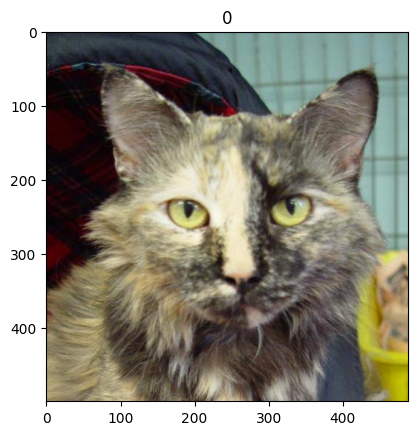

In [7]:
image, label = load('./Cat_Dog_data/train/cat/cat.10.jpg', 0)

fig, ax = plt.subplots()
ax.imshow(image /255.)
ax.set_title(label)
plt.show()

## 2. Data Pipeline

In [8]:
batch_size = 25

In [9]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Data augmentation for training data
train_datagen = ImageDataGenerator(
    rescale=1./255,             # Normalize pixel values
    shear_range=0.2,            # Shear augmentation
    zoom_range=0.2,             # Random zoom
    horizontal_flip=True,       # Random horizontal flip
    rotation_range=20,          # Random rotation
    width_shift_range=0.2,      # Horizontal shift
    height_shift_range=0.2,     # Vertical shift
    validation_split=0.2)       # 20% of data will be used for validation

# Only rescale test data
test_datagen = ImageDataGenerator(rescale=1./255)

# Load training data with validation split
train_generator = train_datagen.flow_from_directory(
    'Cat_Dog_data/train',      # Path to train folder
    target_size=(150, 150),    # Resize all images to 150x150
    batch_size=batch_size,             # Batch size
    class_mode='binary',       # Use 'categorical' for multi-class classification
    subset='training')         # Set as training data

# Load validation data
validation_generator = train_datagen.flow_from_directory(
    'Cat_Dog_data/train',      # Same path as training data
    target_size=(150, 150),
    batch_size=batch_size,
    class_mode='binary',
    subset='validation')       # Set as validation data

# Load test data
test_generator = test_datagen.flow_from_directory(
    'Cat_Dog_data/test',       # Path to test folder
    target_size=(150, 150),
    batch_size=batch_size,
    class_mode='binary')

# Output the number of samples in each generator
print(f"Train samples: {train_generator.samples}")
print(f"Validation samples: {validation_generator.samples}")
print(f"Test samples: {test_generator.samples}")


Found 18000 images belonging to 2 classes.
Found 4500 images belonging to 2 classes.
Found 2500 images belonging to 2 classes.
Train samples: 18000
Validation samples: 4500
Test samples: 2500


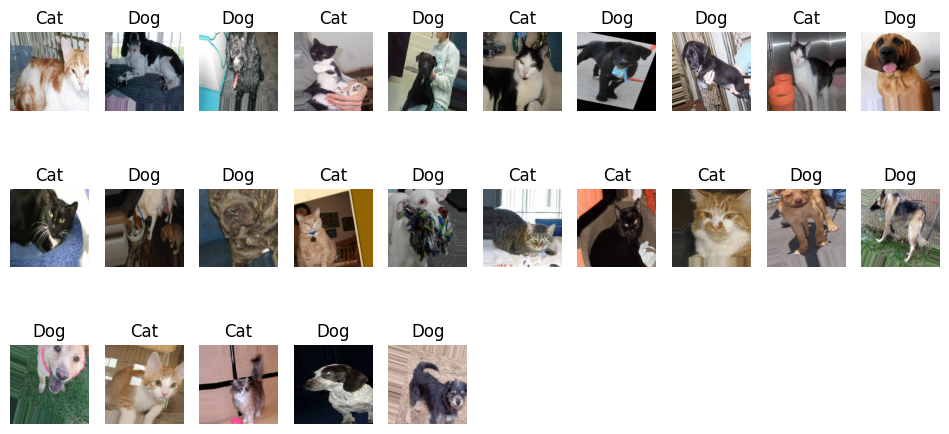

In [10]:
images, labels = next(train_generator)


plt.figure(figsize=(12, 20))

for i in range(batch_size):  # Adjust the range according to the available images
    plt.subplot(10, 10, i + 1)
    plt.imshow(images[i])
    plt.title("Cat" if labels[i] == 0 else "Dog")  # Assuming 0=Cat, 1=Dog
    plt.axis('off')

plt.show()


### 3. Build the model

In [11]:
from keras.layers import Dense, Dropout
from keras.layers import Conv2D, MaxPooling2D, Flatten, BatchNormalization , Input
from keras.models import Sequential

In [12]:
# Define the model
model = Sequential()

# First layer using Input
model.add(Input(shape=(150, 150, 3)))

# First block
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))


# Second block
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))


# Third block
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))


# Fourth block
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))


# Fully connected layers
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))

# Output layer
model.add(Dense(1, activation='sigmoid'))

# สรุปโมเดล
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 148, 148, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 72, 72, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 34, 34, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 15, 15, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 15, 15, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 6272)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       802,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,045,825 (3.99 MB)

 Trainable params: 1,044,865 (3.99 MB)

 Non-trainable params: 960 (3.75 KB)

In [13]:
from tensorflow.keras.optimizers import Adam

model.compile(optimizer=Adam(learning_rate=0.01),
              loss='binary_crossentropy',
              metrics=['accuracy'])

### 4. Train the model

In [14]:
from keras.callbacks import ReduceLROnPlateau,EarlyStopping,ModelCheckpoint

learning_rate_reduction = ReduceLROnPlateau(monitor = 'val_accuracy',
                                            patience=2,
                                            factor=0.5,
                                            min_lr = 0.00001,
                                            verbose = 1)

early_stopping = EarlyStopping(monitor='val_loss',patience= 3,restore_best_weights=True,verbose=0)

In [15]:
steps_per_epoch = train_generator.samples // train_generator.batch_size
validation_steps = validation_generator.samples // validation_generator.batch_size

print(steps_per_epoch)
print(validation_steps)

720
180


In [16]:
history = model.fit(
    train_generator,
    epochs=30,
    validation_data=validation_generator,
    callbacks=[early_stopping, learning_rate_reduction])

c:\Users\nabun\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
720/720 ━━━━━━━━━━━━━━━━━━━━ 284s 391ms/step - accuracy: 0.5848 - loss: 0.7356 - val_accuracy: 0.5738 - val_loss: 0.7245 - learning_rate: 0.0100
Epoch 2/30
720/720 ━━━━━━━━━━━━━━━━━━━━ 280s 388ms/step - accuracy: 0.6671 - loss: 0.6080 - val_accuracy: 0.6220 - val_loss: 0.8027 - learning_rate: 0.0100
Epoch 3/30
720/720 ━━━━━━━━━━━━━━━━━━━━ 278s 386ms/step - accuracy: 0.7301 - loss: 0.5370 - val_accuracy: 0.6822 - val_loss: 0.6203 - learning_rate: 0.0100
Epoch 4/30
720/720 ━━━━━━━━━━━━━━━━━━━━ 278s 386ms/step - accuracy: 0.7743 - loss: 0.4777 - val_accuracy: 0.5113 - val_loss: 0.8157 - learning_rate: 0.0100
Epoch 5/30
720/720 ━━━━━━━━━━━━━━━━━━━━ 278s 385ms/step - accuracy: 0.6880 - loss: 0.5877 - val_accuracy: 0.7436 - val_loss: 0.5356 - learning_rate: 0.0100
Epoch 6/30
720/720 ━━━━━━━━━━━━━━━━━━━━ 277s 385ms/step - accuracy: 0.7703 - loss: 0.4770 - val_accuracy: 0.7773 - val_loss: 0.4554 - learning_rate: 0.0100
Epoch 7/30
720/720 ━━━━━━━━━━━━━━━━━━━━ 276s 383ms/step - accura

Last train accuracy: 0.9220555424690247
Last validation accuracy: 0.9268888831138611


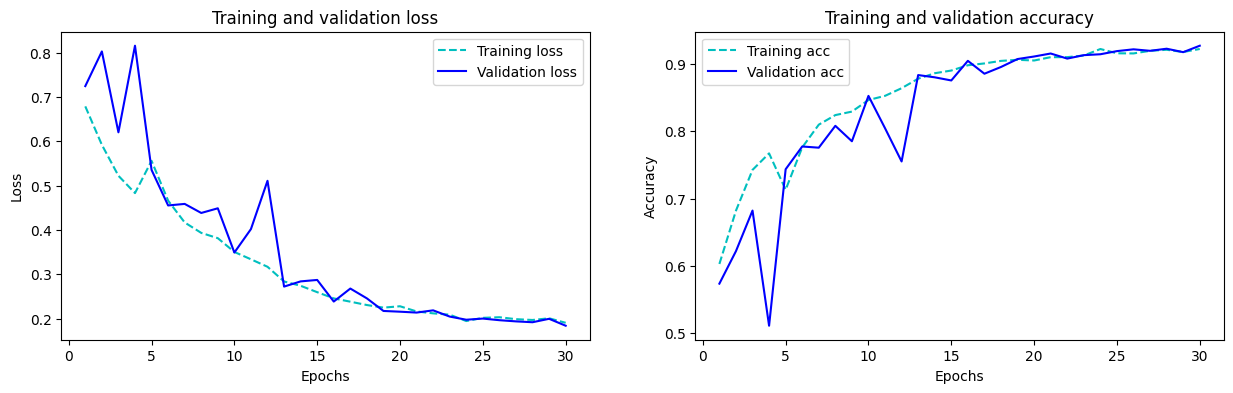

In [17]:
show_result(history)

### 5. Model Evaluation

In [18]:
# all_images = []
# all_labels = []

# for images, labels in test_generator:
#     all_images.extend(images)
#     all_labels.extend(labels)

# all_images = np.array(all_images)
# all_labels = np.array(all_labels)

all_images = []
all_labels = []

# Loop through the test_generator for the number of batches
for i in range(len(test_generator)):
    images, labels = test_generator[i]
    all_images.extend(images)
    all_labels.extend(labels)

# Convert lists to numpy arrays
all_images = np.array(all_images)
all_labels = np.array(all_labels)


In [19]:
len(all_images) , len(all_labels)

(2500, 2500)

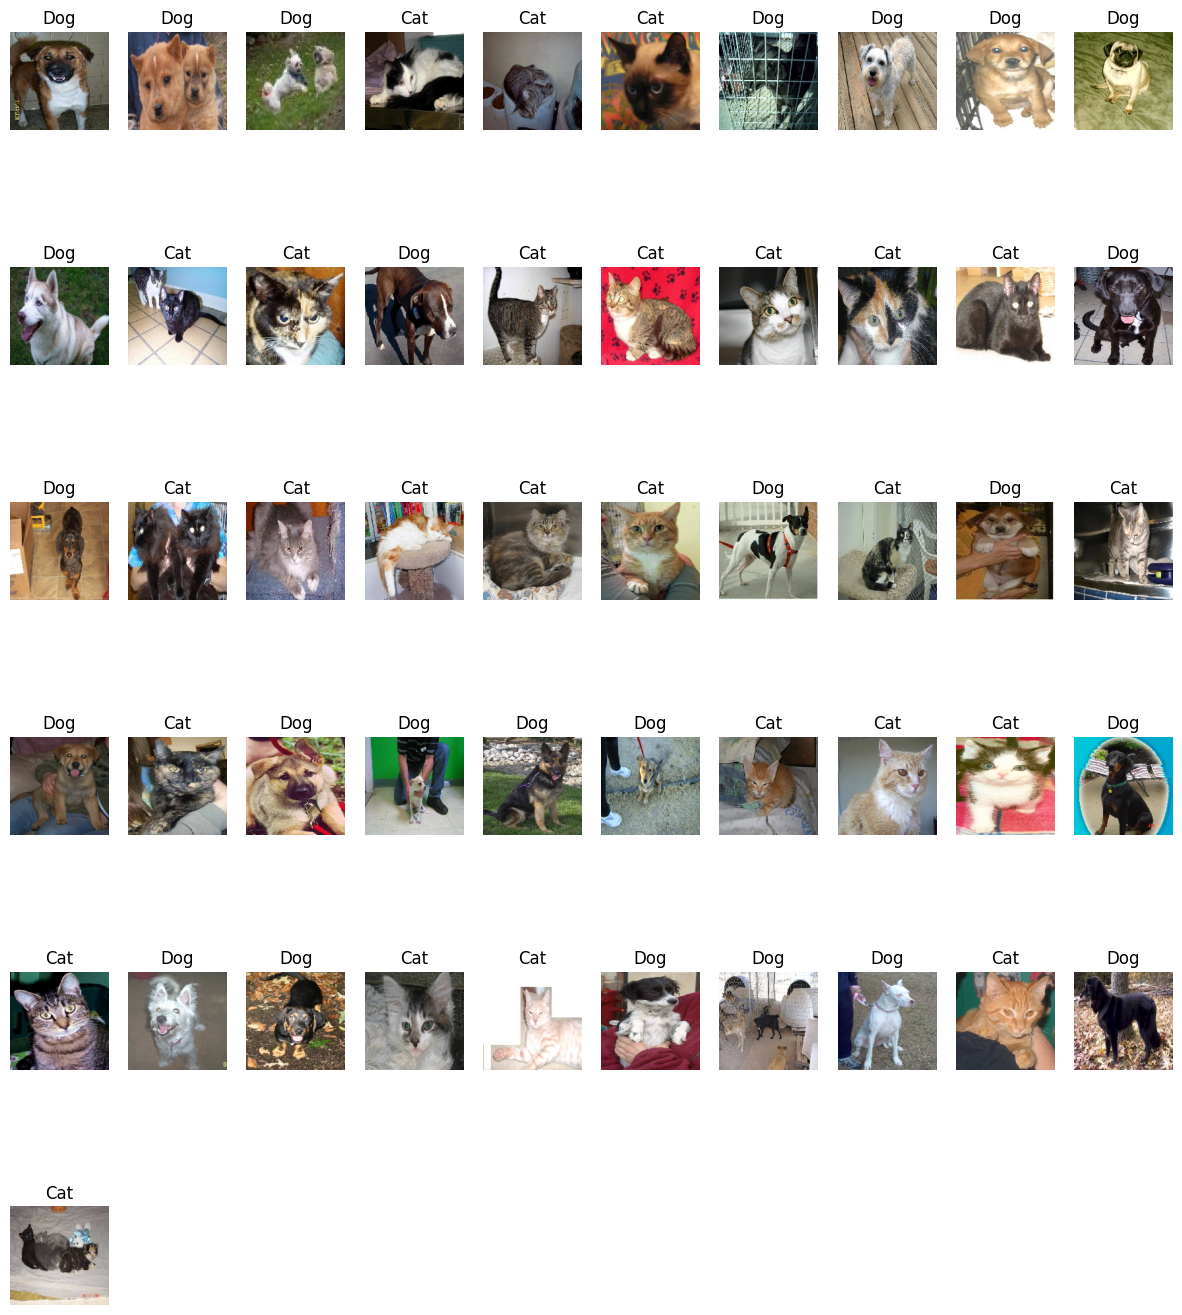

In [20]:
# Plot all images
plt.figure(figsize=(15, 30))

# Adjust the range according to the available images
for i in range(len(all_images)):
    plt.subplot(10, 10, i + 1)
    plt.imshow(all_images[i])
    plt.title("Cat" if all_labels[i] == 0 else "Dog")  # Assuming 0=Cat, 1=Dog
    plt.axis('off')
    if i >= 50:
      break

plt.show()

In [21]:
# features, labels = next(test_generator)

In [22]:
predict = evaluation_report(model, all_images, all_labels)

79/79 ━━━━━━━━━━━━━━━━━━━━ 6s 71ms/step
[[1136  114]
 [  65 1185]]
              precision    recall  f1-score   support

         0.0       0.95      0.91      0.93      1250
         1.0       0.91      0.95      0.93      1250

    accuracy                           0.93      2500
   macro avg       0.93      0.93      0.93      2500
weighted avg       0.93      0.93      0.93      2500

Loss: 0.16769331693649292 Accuracy: 0.9283999800682068


Predict shape: (2500,)
Label shape: (2500,)
Feature shape: (2500, 150, 150, 3)
Number of correct predictions: 30


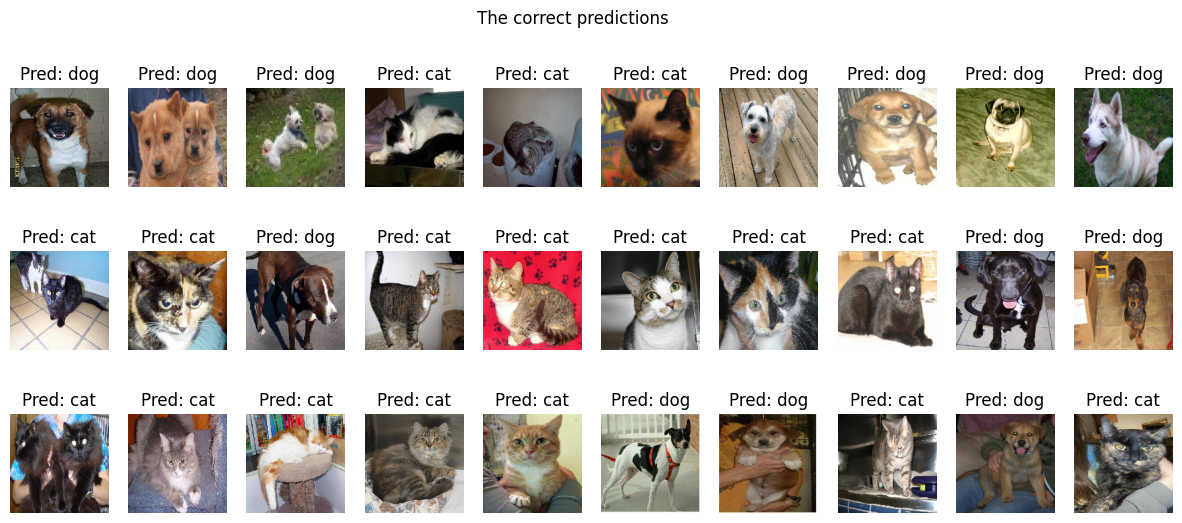

In [23]:
show_correct_prediction(predict, all_images, all_labels, img_size=150, channel=3)

Predict shape: (2500,)
Label shape: (2500,)
Feature shape: (2500, 150, 150, 3)
Number of false predictions: 30


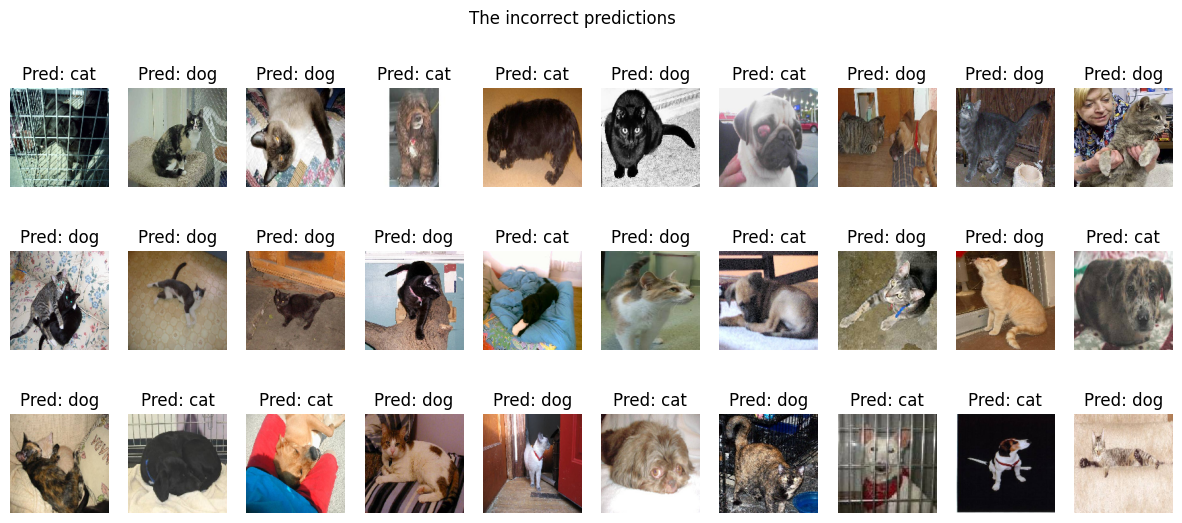

In [24]:
show_false_prediction(predict, all_images, all_labels, img_size=150, channel=3)

### 6.Try to play

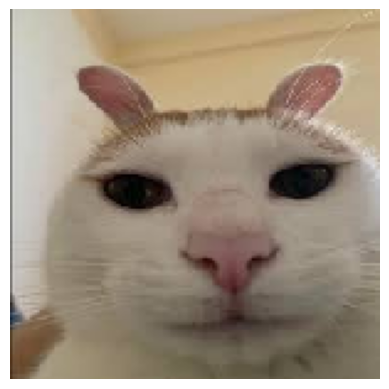

In [25]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array

img = load_img("thisisacat.jpg", target_size=(150, 150))
img_array = img_to_array(img)

plt.imshow(img_array.astype('uint8'))
plt.axis('off')  # ซ่อนแกน
plt.show()

In [26]:
img_array = img_array / 255.0
img_array = np.expand_dims(img_array, axis=0)

predictions = model.predict(img_array)
predicted_class = np.argmax(predictions[0])

result = "Cat" if predicted_class == 0 else "Dog"

print(f"Finally !!!!! => Prediction : {result}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Finally !!!!! => Prediction : Cat
